In [ ]:
# 고급 회귀 기법

In [ ]:
자전거 대여 수요 예측: https://www.kaggle.com/competitions/bike-sharing-demand/data
주택 가격: https://www.kaggle.com/competitions/house-prices-advanced-regression-techniques/data

### 데이터 사전 처리(Preprocessing)

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

In [ ]:
# 데이터 불러오기
house_df_org  = #TODO:YOUR_CODE_HERE
house_df = house_df_org.copy()
house_df.head(3)

In [ ]:
house_df.info()

In [ ]:
house_df.shape

(1460, 81)

In [ ]:
print('### Feature type ###')
print(house_df.iloc[:,:-1].dtypes.value_counts())

print('\n### Null Feature ###')
isnull_series = house_df.isnull().sum() # Null 데이터의 갯수 확인하기 #TODO:YOUR_CODE_HERE
print(isnull_series[isnull_series > 0].sort_values(ascending=False))

In [ ]:
# 시각화를 통해 SalePrice의 분포도 확인

from scipy import stats

fig, axs = plt.subplots(1,3, figsize = (15,6))

sns.histplot(house_df["SalePrice"], ax =axs[0], kde=True)
stats.probplot(house_df["SalePrice"], dist='norm', fit=True, plot=axs[1])
sns.histplot(np.log1p(house_df["SalePrice"]), ax=axs[2], kde=True)

axs[0].set_title("Original Sale Price Histogram")
axs[2].set_title("Log Transformed Sale Price Histogram")

for label in axs[0].get_xticklabels():
    label.set_rotation(45)
    label.set_ha('right')

plt.tight_layout()
plt.show()

In [ ]:
# # 피처 제거
# # Null 데이터가 100개 이상인 피처 제거
# TODO: YOUR_CODE_HERE(["Id", "PoolQC", "MiscFeature", "Alley", "Fence"], axis=1, inplace=True)

# 종속 변수 로그 변환
org_SalePrice = house_df["SalePrice"]
house_df["SalePrice"] = np.log1p(house_df["SalePrice"])

# 결측값 대체 - 숫자형
numeric_cols = house_df.select_dtypes(include=[np.number]).columns
house_df[numeric_cols] = house_df[numeric_cols].fillna(house_df[numeric_cols].mean())

# 원-핫 인코딩 - 카테고리형
house_df_ohe = # TODO: YOUR_CODE_HERE

# 결과 확인
print(house_df_ohe.head())

In [ ]:
print("원-핫 인코딩 전 shape:", house_df.shape)
print("원-핫 인코딩 후 shape:", house_df_ohe.shape)

원-핫 인코딩 전 shape: (1460, 76)
원-핫 인코딩 후 shape: (1460, 287)


### 선형 회귀 모델의 학습/예측/평가

#### 기본 예측/평가

##### RMSE함수

In [ ]:
def get_rmse(model):
    pred = model.predict(X_test)
    mse = mean_squared_error(y_test , pred)
    rmse = np.sqrt(mse)
    print(f'{model.__class__.__name__} 로그 변환된 RMSE: {np.round(rmse, 4)}')

    return rmse

def get_rmses(models):
    rmses = []

    for model in models:
        rmse = get_rmse(model)
        rmses.append(rmse)

    return rmses

In [ ]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

X_features = house_df_ohe.drop('SalePrice',axis=1, inplace=False)
y_target = house_df_ohe['SalePrice']

X_train, X_test, y_train, y_test = train_test_split(X_features, y_target, test_size=0.2, random_state=156)

# LinearRegression, Ridge, Lasso 모델 적용하기
lr_reg = # TODO: YOUR_CODE_HERE
ridge_reg = # TODO: YOUR_CODE_HERE
lasso_reg = # TODO: YOUR_CODE_HERE

lr_reg.fit(X_train, y_train)
ridge_reg.fit(X_train, y_train)
lasso_reg.fit(X_train, y_train)

# 예측 평가
models = [lr_reg, ridge_reg, lasso_reg]
rmses = get_rmses(models)

LinearRegression 로그 변환된 RMSE: 0.1321
Ridge 로그 변환된 RMSE: 0.1283
Lasso 로그 변환된 RMSE: 0.1763


##### 회귀 계수 시각화 함수

In [ ]:
# 상위, 하위 10개 coefficients 추출
def get_top_bottom_coef(model):
    # coef series
    coef = pd.Series(model.coef_, index = X_features.columns)

    coef_high = coef.sort_values(ascending=False).head(10)
    coef_low = coef.sort_values(ascending=False).tail(10)
    return coef_high, coef_low

# 회귀 계수 시각화
def visualize_coefficient(models, xlim=None):
    fig, axs = plt.subplots(3,1, figsize=(24,20))
    fig.tight_layout()

    for i, model in enumerate(models):
        coef_high, coef_low = get_top_bottom_coef(model)
        coef_concat = pd.concat( [coef_high , coef_low], axis=0 )

        axs[i].set_title(model.__class__.__name__ , size=25, x= 0.9, y= 0.1)

        # font size 조정
        for label in (axs[i].get_xticklabels() + axs[i].get_yticklabels()):
            label.set_fontsize(22)

        # x축 범위
        if xlim:
            axs[i].set_xlim(xlim)

        sns.barplot(x=coef_concat.values, y=coef_concat.index , ax=axs[i])

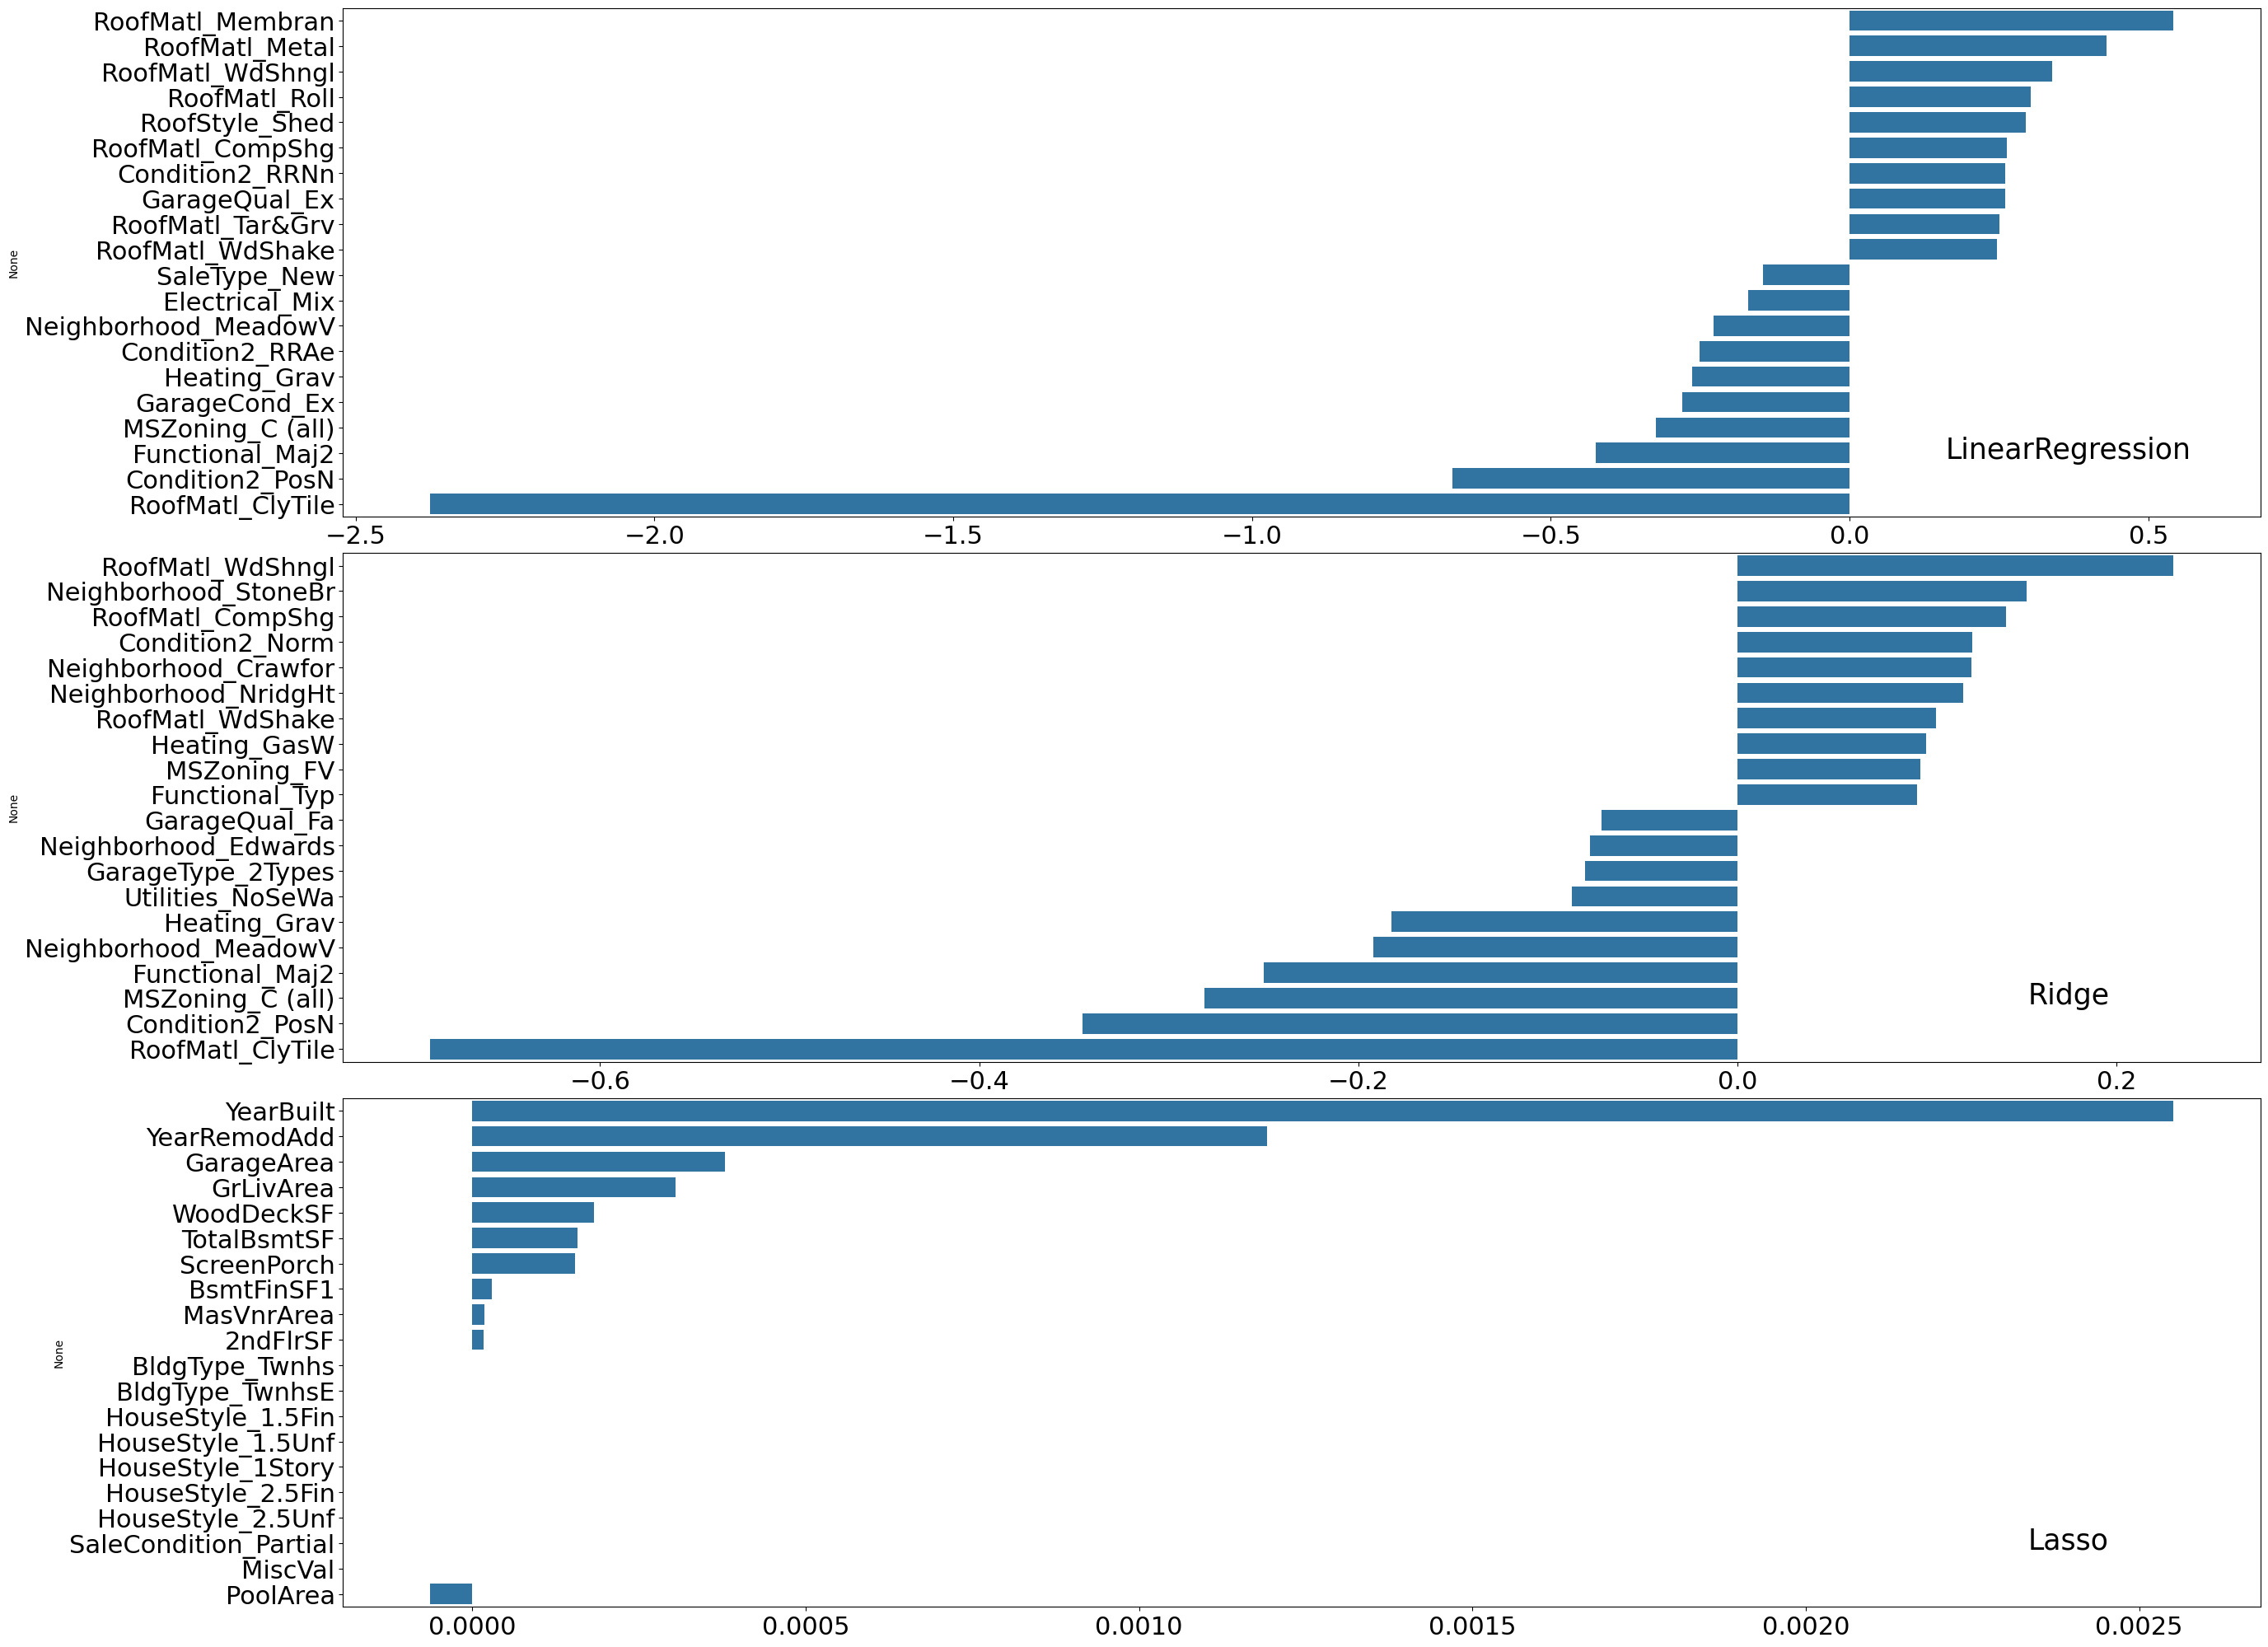

In [ ]:
# LinearRegression, Ridge, Lasso
models = [lr_reg, ridge_reg, lasso_reg]
visualize_coefficient(models)

#### 교차검증

##### 교차검증 평균 RMSE 함수

In [ ]:
from sklearn.model_selection import cross_val_score

def get_avg_rmse_cv(models):

    for model in models:
        mse_scores = -1*cross_val_score(model, X_features, y_target,
                                        scoring="neg_mean_squared_error", cv=5)
        rmse_scores = np.sqrt(mse_scores)
        rmse_avg = np.mean(rmse_scores)

        print(f"{model.__class__.__name__} CV RMSE 리스트: {np.round(rmse_scores,3)}")
        print(f"{model.__class__.__name__} CV 평균 RMSE: {rmse_avg:.3f}\n")

In [ ]:
# LinearRegression, Ridge, Lasso
lr_reg = LinearRegression()
ridge_reg = Ridge()
lasso_reg = Lasso()

models = [lr_reg, ridge_reg, lasso_reg]
get_avg_rmse_cv(models)

#### GridSearchCV

##### 하이퍼 파라미터 도출 함수

In [ ]:
from sklearn.model_selection import GridSearchCV

def get_best_params(model, params):
    model_name = model.__class__.__name__
    grid_cv = GridSearchCV(model, param_grid=params,
                           scoring='neg_mean_squared_error', cv=5)

    grid_cv.fit(X_features, y_target)
    best_rmse = np.sqrt(-1* grid_cv.best_score_)

    print(f'{model_name} GridSearchCV 최적 평균 RMSE: {np.round(best_rmse, 4)}, 최적 alpha:{grid_cv.best_params_}')

    return grid_cv.best_estimator_

In [ ]:
# 하이퍼 파라미터
ridge_params = { 'alpha':[0.05, 0.1, 1, 5, 8, 10, 12, 15, 20] }
lasso_params = { 'alpha':[0.001, 0.005, 0.008, 0.05, 0.03, 0.1, 0.5, 1,5, 10] }

# Ridge, Lasso
ridge_reg = Ridge()
lasso_reg = Lasso()

best_ridge = get_best_params(ridge_reg, ridge_params)
best_lasso = get_best_params(lasso_reg, lasso_params)

Ridge GridSearchCV 최적 평균 RMSE: 0.1417, 최적 alpha:{'alpha': 12}
Lasso GridSearchCV 최적 평균 RMSE: 0.1419, 최적 alpha:{'alpha': 0.001}


In [ ]:
# 최적 하이퍼 파라미터로 Ridge, Lasso 수정
lr_reg = LinearRegression()
ridge_reg = Ridge(# TODO: YOUR_CODE_HERE)
lasso_reg = Lasso(# TODO: YOUR_CODE_HERE)

lr_reg.fit(X_train, y_train)
ridge_reg.fit(X_train, y_train)
lasso_reg.fit(X_train, y_train)

# test set RMSE
models = [lr_reg, ridge_reg, lasso_reg]
get_rmses(models)

# 회귀 계수 시각화
models = [lr_reg, ridge_reg, lasso_reg]
visualize_coefficient(models, xlim=(-2.5,0.6))

#### 피처 로그 변환
데이터 왜곡 로그 변환 후 성능 평가

In [ ]:
from scipy.stats import skew

# 숫자형 피처 컬럼 index
features_index = house_df.dtypes[house_df.dtypes != 'object'].index

# 피처(열)별로 왜곡도 산출
skew_features = house_df[features_index].apply(lambda x : skew(x), axis=0)

# 왜곡도가 1 이상
skew_features_top = skew_features[skew_features > 1]
print(skew_features_top.sort_values(ascending=False))

In [ ]:
# 피처 로그 변환
house_df[skew_features_top.index] = np.log1p(house_df[skew_features_top.index])

# 원-핫 인코딩
house_df_ohe2 = pd.get_dummies(house_df)

# 데이터 재분리
X_features = house_df_ohe2.drop('SalePrice',axis=1, inplace=False)
y_target = house_df_ohe2['SalePrice']

X_train, X_test, y_train, y_test = train_test_split(X_features, y_target, test_size=0.2, random_state=156)

In [ ]:
# 하이퍼 파라미터
ridge_params = { 'alpha':[0.05, 0.1, 1, 5, 8, 10, 12, 15, 20] }
lasso_params = { 'alpha':[0.001, 0.005, 0.008, 0.05, 0.03, 0.1, 0.5, 1,5, 10] }

# Ridge, Lasso
ridge_reg = Ridge()
lasso_reg = Lasso()

best_ridge = get_best_params(ridge_reg, ridge_params)
best_lasso = get_best_params(lasso_reg, lasso_params)

In [ ]:
# 최적 하이퍼 파라미터로 Ridge, Lasso 수정
lr_reg = LinearRegression()
ridge_reg = Ridge(# TODO: YOUR_CODE_HERE)
lasso_reg = Lasso(# TODO: YOUR_CODE_HERE)

lr_reg.fit(X_train, y_train)
ridge_reg.fit(X_train, y_train)
lasso_reg.fit(X_train, y_train)

# 회귀 계수 시각화
models = [lr_reg, ridge_reg, lasso_reg]
visualize_coefficient(models, xlim=(-1.7,0.5))

#### 이상치 제거

In [ ]:
plt.scatter(house_df_org["GrLivArea"] , house_df_org["SalePrice"], c="darkorange")
plt.ylabel('SalePrice')
plt.xlabel('GrLivArea')

# 추후 확인한 이상치 표시
idx = (house_df_org["GrLivArea"] > 4000) & (house_df_org["SalePrice"] < 200000)
outlier_df = house_df_org[idx]
plt.scatter(outlier_df["GrLivArea"] , outlier_df["SalePrice"], s=300, c="r", alpha=0.5 )

plt.show()

In [ ]:
# GrLivArea, SalePrice 모두 로그 변환 하였으므로 반영한 조건 생성
cond1 = house_df_ohe2['GrLivArea'] > np.log1p(4000)
cond2 = house_df_ohe2['SalePrice'] < np.log1p(500000)
outlier_index = house_df_ohe2[cond1 & cond2].index

house_df_ohe3 = house_df_ohe2.drop(outlier_index , axis=0, inplace=False)

print('이상치 삭제 전 house_df_ohe2 shape:', house_df_ohe2.shape)
print('이상치 삭제 후 house_df_ohe3 shape:', house_df_ohe3.shape)

In [ ]:
# 데이터 재분리
X_features = house_df_ohe3.drop('SalePrice',axis=1, inplace=False)
y_target = house_df_ohe3['SalePrice']

X_train, X_test, y_train, y_test = train_test_split(X_features, y_target, test_size=0.2, random_state=156)

In [ ]:
# 하이퍼 파라미터
ridge_params = { 'alpha':[0.05, 0.1, 1, 5, 8, 10, 12, 15, 20] }
lasso_params = { 'alpha':[0.001, 0.005, 0.008, 0.05, 0.03, 0.1, 0.5, 1,5, 10] }

# Ridge, Lasso
ridge_reg = Ridge()
lasso_reg = Lasso()

best_ridge = get_best_params(ridge_reg, ridge_params)
best_lasso = get_best_params(lasso_reg, lasso_params)

In [ ]:
# 최적 하이퍼 파라미터로 Ridge, Lasso 수정
lr_reg = LinearRegression()
ridge_reg = Ridge(# TODO: YOUR_CODE_HERE)
lasso_reg = Lasso(# TODO: YOUR_CODE_HERE)

lr_reg.fit(X_train, y_train)
ridge_reg.fit(X_train, y_train)
lasso_reg.fit(X_train, y_train)

# test set RMSE
models = [lr_reg, ridge_reg, lasso_reg]
rmses = get_rmses(models)

LinearRegression 로그 변환된 RMSE: 0.1283
Ridge 로그 변환된 RMSE: 0.1035
Lasso 로그 변환된 RMSE: 0.1003


### 회귀 트리 학습/예측/평가

In [ ]:
from xgboost import XGBRegressor

xgb_params = {'n_estimators':[1000]}
xgb_reg = XGBRegressor(learning_rate=0.05, colsample_bytree=0.5, subsample=0.8)

best_xgb = get_best_params(xgb_reg, xgb_params)

In [ ]:
from lightgbm import LGBMRegressor

lgbm_params = {'n_estimators':[1000]}
lgbm_reg = LGBMRegressor(learning_rate=0.05, num_leaves=4,
                         subsample=0.6, colsample_bytree=0.4, reg_lambda=10, n_jobs=-1)

best_lgbm = get_best_params(lgbm_reg, lgbm_params)

### 회귀 모델들의 예측 결과 혼합을 통한 최종 예측

##### 혼합 RMSE함수

In [ ]:
def get_rmse_pred(preds):
    for key in preds.keys():
        prediction = preds[key]

        mse = mean_squared_error(y_test, prediction)
        rmse = np.sqrt(mse)

        print(f"{key} 모델 RMSE: {rmse:.4f}")

In [ ]:
ridge_reg = Ridge(alpha=8)
lasso_reg = Lasso(alpha=0.001)

ridge_reg.fit(X_train, y_train)
lasso_reg.fit(X_train, y_train)

ridge_pred = ridge_reg.predict(X_test)
lasso_pred = lasso_reg.predict(X_test)

# 혼합 예측
fusion_pred = 0.4*ridge_pred + 0.6*lasso_pred

# 개별 예측, 혼합 예측 평가
preds = {
    "Ridge": ridge_pred,
    "Lasso": lasso_pred,
    "Fusion": fusion_pred
}

get_rmse_pred(preds)

### 스태킹 앙상블 회귀

##### CV 스태킹 함수

In [ ]:
import numpy as np
from sklearn.model_selection import KFold
from sklearn.linear_model import Ridge, Lasso
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
import pandas as pd

# 데이터 프레임, 시리즈 -> Numpy 배열 변환
X_train = X_train.values if isinstance(X_train, pd.DataFrame) else X_train
X_test = X_test.values if isinstance(X_test, pd.DataFrame) else X_test
y_train = y_train.values if isinstance(y_train, pd.Series) else y_train

# 개별 모델별 메타 데이터 생성 함수
def get_stacking_base_datasets(model, X_train, y_train, X_test, n_folds):
    kf = KFold(n_splits=n_folds, shuffle=True, random_state=0)

    train_cnt = X_train.shape[0]
    test_cnt = X_test.shape[0]
    train_meta = np.zeros((train_cnt, 1))
    test_meta = np.zeros((test_cnt, n_folds))

    print(f'{model.__class__.__name__} model 시작')

    for i, (train_fold_idx, test_fold_idx) in enumerate(kf.split(X_train)):
        print(f'\t폴드 세트: {i+1} 시작')
        x_train_fold = X_train[train_fold_idx]
        y_train_fold = y_train[train_fold_idx]
        x_test_fold = X_train[test_fold_idx]

        model.fit(x_train_fold, y_train_fold)

        train_meta[test_fold_idx, :] = model.predict(x_test_fold).reshape(-1, 1)

        test_meta[:, i] = model.predict(X_test)

    test_meta_mean = np.mean(test_meta, axis=1).reshape(-1, 1)

    return train_meta, test_meta_mean

# 각 모델 학습
ridge_reg = Ridge(alpha=8)
lasso_reg = Lasso(alpha=0.001)
xgb_reg = XGBRegressor(n_estimators=1000, learning_rate=0.05, colsample_bytree=0.5, subsample=0.8)
lgbm_reg = LGBMRegressor(n_estimators=1000, learning_rate=0.05, num_leaves=4, subsample=0.6,
                         colsample_bytree=0.4, reg_lambda=10, n_jobs=-1)

# 각 모델 메타 데이터 생성
ridge_train, ridge_test = get_stacking_base_datasets(ridge_reg, X_train, y_train, X_test, 5)
lasso_train, lasso_test = get_stacking_base_datasets(lasso_reg, X_train, y_train, X_test, 5)
xgb_train, xgb_test = get_stacking_base_datasets(xgb_reg, X_train, y_train, X_test, 5)
lgbm_train, lgbm_test = get_stacking_base_datasets(lgbm_reg, X_train, y_train, X_test, 5)

# 결과 확인
print(ridge_train.shape, ridge_test.shape)
print(lasso_train.shape, lasso_test.shape)
print(xgb_train.shape, xgb_test.shape)
print(lgbm_train.shape, lgbm_test.shape)


In [ ]:
# 최종 메타 데이터 결합
final_X_train_meta = np.concatenate((ridge_train, lasso_train, xgb_train, lgbm_train), axis=1)
final_X_test_meta = np.concatenate((ridge_test, lasso_test, xgb_test, lgbm_test), axis=1)

# 최종 메타 모델 학습/예측/평가
meta_model_lasso = Lasso(alpha=0.0005)

meta_model_lasso.fit(final_X_train_meta, y_train)
meta_predict = meta_model_lasso.predict(final_X_test_meta)
rmse = np.sqrt( mean_squared_error(y_test, meta_predict))

print(f"스태킹 회귀 모델 RMSE: {rmse:.4f}")